# Direct GMIA Tutorial

## Imports

In [1]:
# automatically reload my imports (%aimport) every time they are used
# cool feature for development
#%load_ext autoreload
#%autoreload 1
#%aimport attack_scripts.script_direct_mia
#mia = script_direct_mia.DirectMia
#miavis = script_direct_mia.AttackVisualisations

import sys
sys.path.append('..')

from pa.gmia import DirectMia as mia
from pa.gmia import AttackVisualisations as miavis

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

## Function Definitions

In [3]:
def create_model(input_shape, n_categories):
  """Architecture of the attacker and reference models.

  Parameters
  ----------
  input_shape : tuple
      Dimensions of the input for the target/training
  n_categories : int
      number of categories for the prediction
  models.

  Returns
  -------
  tensorflow.python.keras.engine.sequential.Sequential
      A convolutional neuronal network model.
  """
  model = Sequential()

  # first connvolution layer
  model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(
      1, 1), padding='same', input_shape=input_shape))
  model.add(Activation('relu'))

  # max pooling layer
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

  # second convolution layer
  model.add(Conv2D(filters=64, kernel_size=(
      5, 5), strides=(1, 1), padding='same'))
  model.add(Activation('relu'))

  # max pooling layer
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

  # fully connected layer
  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation('relu'))

  # drop out
  model.add(Dropout(rate=0.5))

  # fully connected layer
  model.add(Dense(n_categories))
  model.add(Activation('softmax'))

  return model

In [4]:
def load_fashion_mnist():
  """Loads and preprocesses the MNIST dataset.

  Returns
  -------
  tuple
      (training data, training labels, test data, test labels)
  """
  train, test = tf.keras.datasets.fashion_mnist.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # Normalize the data to a range between 0 and 1
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # Reshape the images to (28, 28, 1)
  train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
  test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

  train_labels = np.array(train_labels, dtype=np.int32)
  test_labels = np.array(test_labels, dtype=np.int32)

  # Convert a class vector (integers) to binary class matrix (one-hot enc.)
  train_labels_cat = tf.keras.utils.to_categorical(train_labels, num_classes=10)
  test_labels_cat = tf.keras.utils.to_categorical(test_labels, num_classes=10)

  return train_data, train_labels, train_labels_cat, test_data, test_labels, test_labels_cat

## Load and split the data

In [5]:
train_data, train_labels, train_labels_cat, test_data, test_labels, test_labels_cat = load_fashion_mnist()

np.random.seed(0)
np.random.shuffle(train_data)
np.random.seed(0)
np.random.shuffle(train_labels)
np.random.seed(0)
np.random.shuffle(train_labels_cat)

np.random.seed(0)
np.random.shuffle(test_data)
np.random.seed(0)
np.random.shuffle(test_labels)
np.random.seed(0)
np.random.shuffle(test_labels_cat)

# Used to train the reference models 
reference_train_data = train_data[:40000]
reference_train_labels = train_labels[:40000]
reference_train_labels_cat = train_labels_cat[:40000]

# Used to train the target models
target_train_data = train_data[40000:50000]
target_train_labels = train_labels[40000:50000]
target_train_labels_cat = train_labels_cat[40000:50000]

# Used for the evaluation of the attack
attack_eval_data = train_data[40000:]
attack_eval_labels = train_labels[40000:]
attack_eval_labels_cat = train_labels_cat[40000:]

input_shape = (28, 28, 1)
number_classes = 10

In [9]:
# Create the training sets for the reference models
number_reference_models = 100
background_knowledge_size = 40000
training_set_size = 10000
path = '../tests/integration/fixtures/data_fashion_mnist/records_per_reference_model.npy'

# Please create a data directory if you run this line the first time
#records_per_reference_model = mia.assign_records_to_reference_models(
#                                                    reference_train_data,
#                                                    number_reference_models,
#                                                    background_knowledge_size,
#                                                    training_set_size, path)

# You can also simply load this file if it exists
records_per_reference_model = np.load(path)

## Train the Target Model

In [10]:
def create_compile_model():
  input_shape = (28, 28, 1)
  number_classes = 10
  
  model = create_model(input_shape, number_classes)
  
  optimizer = optimizers.Adam(lr=0.0001)
  loss = 'categorical_crossentropy'
  metrics = ["accuracy"]  
  model.compile(optimizer, loss=loss, metrics=metrics)

  return model

In [12]:
path = '../tests/integration/fixtures/data_fashion_mnist/target_model'
epochs = 50
batch_size = 50

target_model = create_compile_model()

#target_model.fit(target_train_data, target_train_labels_cat, epochs=epochs,
#                 batch_size=batch_size, validation_data=(test_data, test_labels_cat))


#target_model.save(path)

# Show the target model structure
#target_model.summary()

# Load the target_model
target_model = tf.keras.models.load_model(path)

## Train the Reference Models

In [13]:
model_path = '../tests/integration/fixtures/data_fashion_mnist/reset_target_model'
save_path = '../tests/integration/fixtures/data_fashion_mnist/reference_model'
print_progress = True

epochs = 50
batch_size = 50

#reference_models = mia.train_reference_models(create_compile_model,
#                                              records_per_reference_model,
#                                              reference_train_data,
#                                              reference_train_labels_cat,
#                                              epochs, batch_size, save_path)
# Load the models
reference_models = mia.load_models(save_path, number_reference_models)

Progress: Load reference model 0
Progress: Load reference model 1
Progress: Load reference model 2
Progress: Load reference model 3
Progress: Load reference model 4
Progress: Load reference model 5
Progress: Load reference model 6
Progress: Load reference model 7
Progress: Load reference model 8
Progress: Load reference model 9
Progress: Load reference model 10
Progress: Load reference model 11
Progress: Load reference model 12
Progress: Load reference model 13
Progress: Load reference model 14
Progress: Load reference model 15
Progress: Load reference model 16
Progress: Load reference model 17
Progress: Load reference model 18
Progress: Load reference model 19
Progress: Load reference model 20
Progress: Load reference model 21
Progress: Load reference model 22
Progress: Load reference model 23
Progress: Load reference model 24
Progress: Load reference model 25
Progress: Load reference model 26
Progress: Load reference model 27
Progress: Load reference model 28
Progress: Load reference

## Select Target Records

### Generate Intermediate Models

In [14]:
reference_intermediate_models = mia.gen_intermediate_models(reference_models, 10)

### Generate High-Level-Features

In [15]:
path = '../tests/integration/fixtures/data_fashion_mnist/reference_high_level_features.npy'

#reference_high_level_features = mia.extract_high_level_features(
#                                        reference_intermediate_models,
#                                        reference_train_data, path)

# Load the High-Level-Features
reference_high_level_features = np.load(path)

In [16]:
path = '../tests/integration/fixtures/data_fashion_mnist/target_high_level_features.npy'

#target_high_level_features = mia.extract_high_level_features(
#                                        reference_intermediate_models,
#                                        attack_eval_data, path)

# Load High-Level-Features
target_high_level_features = np.load(path)

### Select Target Records using High-Level-Feature-Space

In [17]:
path = '../tests/integration/fixtures/data_fashion_mnist/pairwise_distances_high_level_features_cosine.npy'
metric = 'cosine'

#distances = mia.calc_pairwise_distances(target_high_level_features,
#                                        reference_high_level_features,
#                                        path, metric)

# Load distance array
distances = np.load(path)

In [18]:
neighbor_threshold = 0.15
probability_threshold = 0.1
background_knowledge_size = 40000
training_set_size = 10000

target_records = mia.select_target_records(neighbor_threshold,
                                           probability_threshold,
                                           background_knowledge_size,
                                           training_set_size,
                                           distances)

min_distance:  6.627008979354088e-07
mean n_neighbors:  3797.08055
mean est_n_neighbors:  15188.3222
number of target_records:  16
target_records:  [ 2560  5713  7815  8235  8394 12674 13473 15276 16015 17322 17942 18214
 18493 18538 18657 19662]
number of neighbors:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


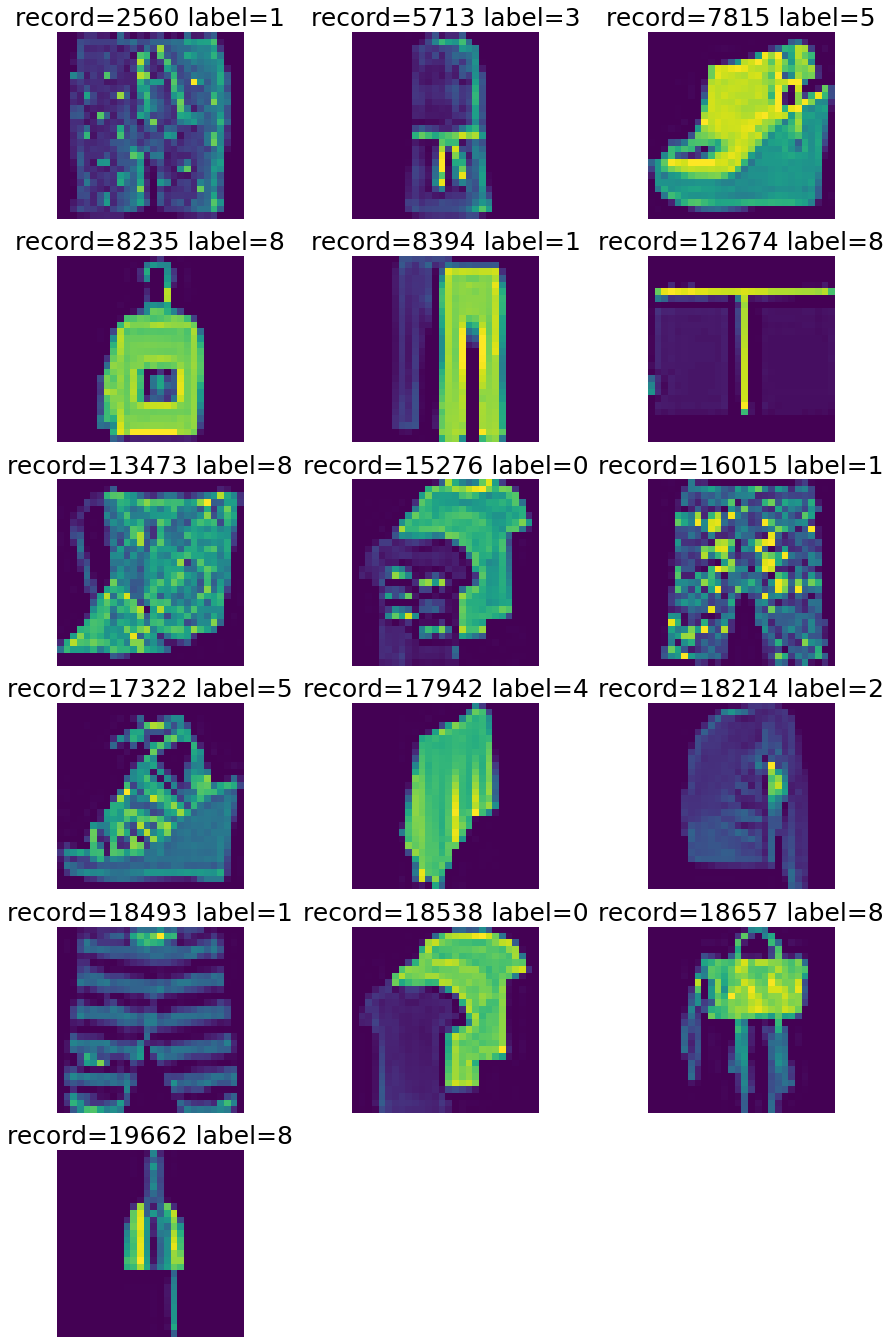

In [19]:
miavis.plot_target_records(target_records, attack_eval_data, attack_eval_labels,
                        input_shape)

## Direct Inference Attack

In [20]:
reference_inferences = mia.get_model_inference(target_records,
                                               attack_eval_data,
                                               attack_eval_labels_cat,
                                               reference_models)

target_inferences = mia.get_model_inference(target_records,
                                            attack_eval_data,
                                            attack_eval_labels_cat,
                                            target_model)

Inference on model  0
Inference on model  1
Inference on model  2
Inference on model  3
Inference on model  4
Inference on model  5
Inference on model  6
Inference on model  7
Inference on model  8
Inference on model  9
Inference on model  10
Inference on model  11
Inference on model  12
Inference on model  13
Inference on model  14
Inference on model  15
Inference on model  16
Inference on model  17
Inference on model  18
Inference on model  19
Inference on model  20
Inference on model  21
Inference on model  22
Inference on model  23
Inference on model  24
Inference on model  25
Inference on model  26
Inference on model  27
Inference on model  28
Inference on model  29
Inference on model  30
Inference on model  31
Inference on model  32
Inference on model  33
Inference on model  34
Inference on model  35
Inference on model  36
Inference on model  37
Inference on model  38
Inference on model  39
Inference on model  40
Inference on model  41
Inference on model  42
Inference on model  4

In [21]:
used_target_records, pchip_references, ecdf_references = mia.sample_reference_losses(
                                                         target_records,
                                                         reference_inferences,
                                                         print_target_information=True)

number of used target records: 16
[ 2560  5713  7815  8235  8394 12674 13473 15276 16015 17322 17942 18214
 18493 18538 18657 19662]


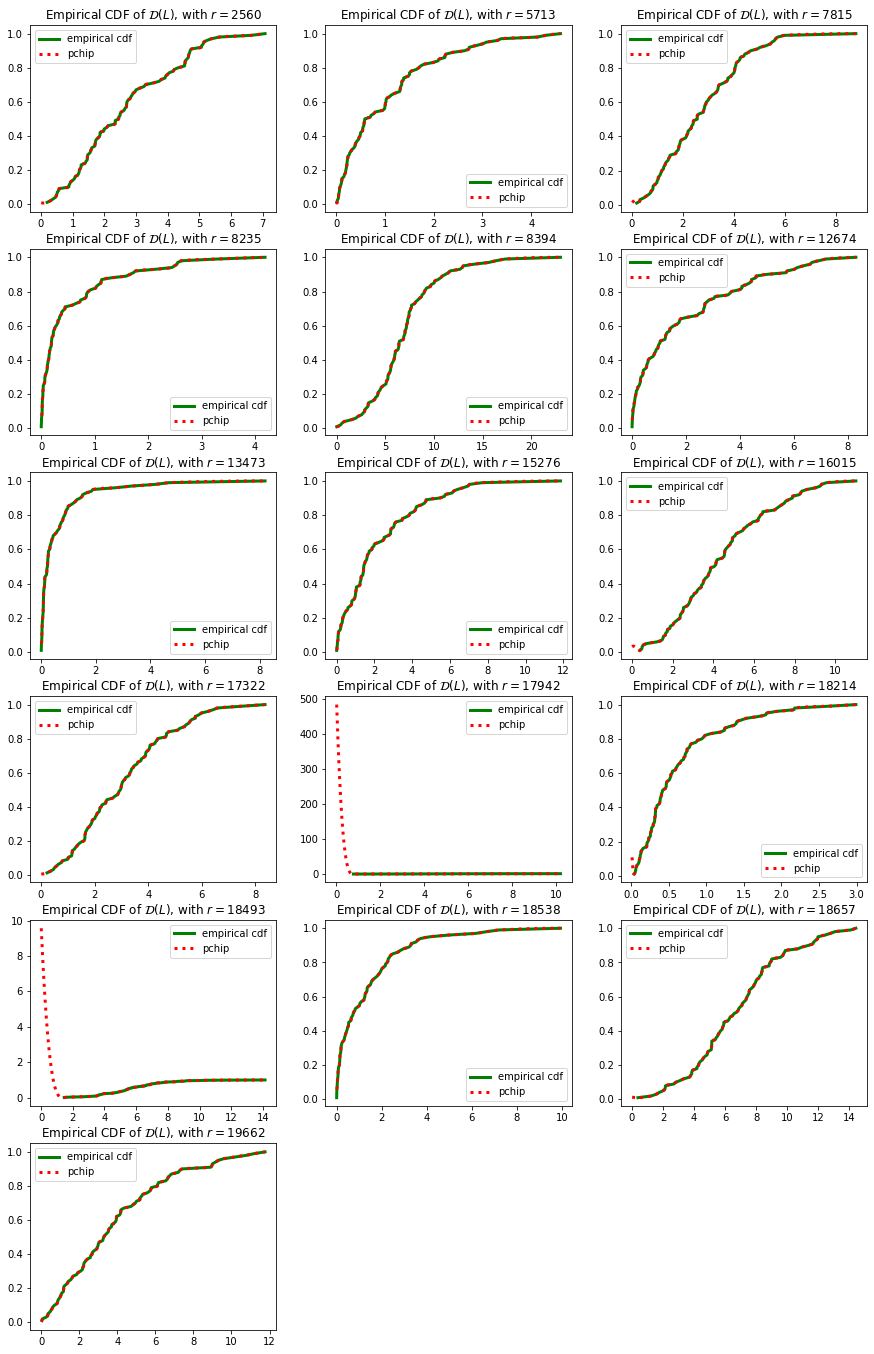

In [22]:
miavis.plot_sampled_reference_losses(used_target_records, ecdf_references,
                                     pchip_references)

In [23]:
cut_off_p_value = 0.05

# The first 10000 samples in the evaluation data were used in the training of
# the target model
ground_truth = np.arange(0,10000)

members, non_members, p_values = mia.hypothesis_test(cut_off_p_value,
                                              pchip_references,
                                              target_inferences,
                                              used_target_records)
print(members, non_members)

[ 2560  7815  8235  8394 18538 18657] [ 5713 12674 13473 15276 16015 17322 17942 18214 18493 19662]


In [24]:
p_values

array([[0.00662767],
       [0.06303277],
       [0.01546083],
       [0.00767324],
       [0.01000037],
       [0.7750883 ],
       [0.59923897],
       [0.06305196],
       [0.60925252],
       [0.26442865],
       [0.6961378 ],
       [0.86854466],
       [0.92493701],
       [0.03587258],
       [0.01902596],
       [0.13798835]])